# A notebook for XLZD 0𝝂𝛽𝛽 requirements studies

### Preliminaries for running on Deucalion

In [1]:
import sys
sys.path.append("./modules")
import os
os.environ[ 'MPLCONFIGDIR' ] = '/home/alindote/.cache/matplotlib'
#print(os.environ.get('MPLCONFIGDIR'))

In [2]:
from Sensitivity_functions import Sensitivity_curve
from Sensitivity_functions import m_bb
from Sensitivity_functions import T_half

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from datetime import datetime 

from scipy.special import gammaincc
from scipy.optimize import curve_fit

In [3]:
%matplotlib inline 
plt.set_cmap('viridis')
matplotlib.rc('font', size=22) 
matplotlib.rc('legend', fontsize=18)    # legend fontsize
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
matplotlib.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rcParams['figure.figsize'] = (12., 9.)    # ... and big plots


float_formatter = "{:.2e}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

colors, linestyles = ['red', 'blue', 'green', 'purple', 'magenta', 'cyan', 'yellow', 'orange'], ['-', ':', '--', '-.', '-', ':', '--', '-.']
colors_Labs = ['lime', 'darkgreen', 'royalblue', 'darkviolet', 'crimson']
font_large = 24

<Figure size 640x480 with 0 Axes>

### Test reading from parameters YAML file

In [5]:
import yaml

with open("parameters_v0.5.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)

#print(data_loaded)
print(data_loaded.get('parameters').get('drift_field'))

{'value': [30, 100, 300], 'unit': 'V/cm', 'definition': 'average drift field in liquid'}


## Requirement: T > 7x10$^{27}$ yr (90% CL)

### Set baseline scenario

In [4]:
### XLZD baseline
# - 60 t mass
# - 3 mm SS/MS in z-only
# - 0.65% Eres
# - 25% LZ gamma BG
# - 99.95% BiPo rejection (with 0.1 mBq/kg Rn-222)
# - installation in Boulby
# - 10 yr exposure time

#                 signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff
baseline_input = [0.853, 0.767, 0.098, 0.65,  0.25, 99.95] 
Lab, LXeMass = 'Boulby-1300', 60

exposure = 10 # yr

### 1. HL vs fraction of LZ $\gamma$ background

In [5]:
# Keep other parameters at their default values
[signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff] = baseline_input

gamma_fractions_list  = [1., 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.25, 0.2, 0.1, 0.05, 0.025]
sens_vs_gammaFrac_10y = []
sens_vs_gammaFrac_15y = []
disc_vs_gammaFrac_10y = []
disc_vs_gammaFrac_15y = []

for gamma_frac in tqdm(gamma_fractions_list):
  
    gamma_args, beta_args = ['XLZD_1:1', LXeMass, gamma_frac], [Lab, BiPo_eff]
    FVmass_range = np.arange(0.1, 0.8*gamma_args[1], 0.1)
  
    exposure = 10
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_gammaFrac_10y.append(sensitivity)
    [Sensitivity, Sensitivity_summed] = Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, \
                                                          eres=eres, gamma_args = gamma_args , 
                                                          beta_args = beta_args, exposuretime = exposure,  
                                                          metric = "Disc_3sigma")
    disc_vs_gammaFrac_10y.append(np.max(Sensitivity))

    
    exposure = 15
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_gammaFrac_15y.append(sensitivity)
    [Sensitivity, Sensitivity_summed] = Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, \
                                                          eres=eres, gamma_args = gamma_args , 
                                                          beta_args = beta_args, exposuretime = exposure,  
                                                          metric = "Disc_3sigma")
    disc_vs_gammaFrac_15y.append(np.max(Sensitivity))

sens_vs_gammaFrac_10y = np.array(sens_vs_gammaFrac_10y)
sens_vs_gammaFrac_15y = np.array(sens_vs_gammaFrac_15y)
disc_vs_gammaFrac_10y = np.array(disc_vs_gammaFrac_10y)
disc_vs_gammaFrac_15y = np.array(disc_vs_gammaFrac_15y)

#print(gamma_fractions_list, sens_vs_gammaFrac)

100%|██████████| 13/13 [23:06<00:00, 106.67s/it]


In [6]:
# use a friendlier vertical scale
sens_vs_gammaFrac_10y /= 1e27
sens_vs_gammaFrac_15y /= 1e27
disc_vs_gammaFrac_10y /= 1e27
disc_vs_gammaFrac_15y /= 1e27

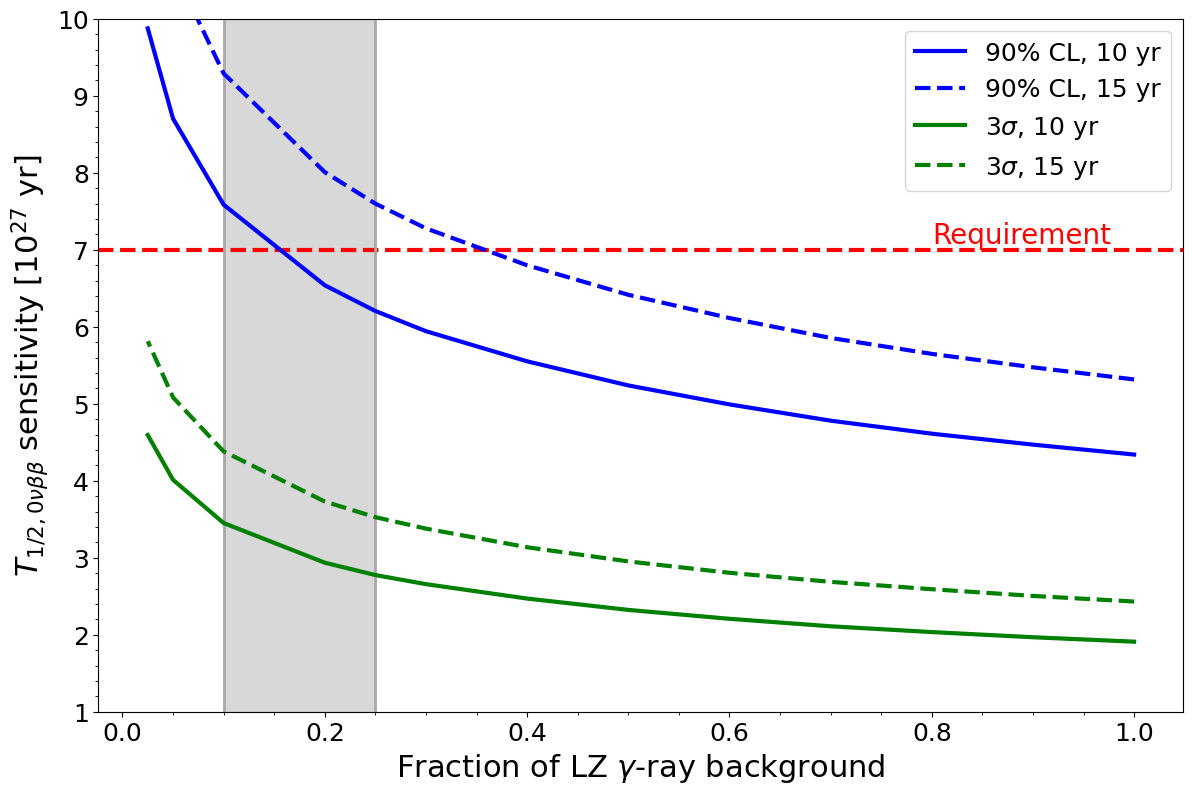

In [9]:
# Make the plot
fig, ax = plt.subplots(figsize = (14, 9))

# Requirement line
plt.axhline(7, ls = "--", lw = 3, color = "red")
plt.text(0.8, 7, 'Requirement', ha = 'left', va = 'bottom', color = 'red', size = 20)
# Band showing baseline and optimistic scenarios range
plt.vlines(0.1, 1, 10, lw = 2, color = "darkgrey")
#plt.text(0.095, 1.95e28, "progressive", va = "top", ha = "right",color = "dimgrey", size = 18, rotation = 90)
plt.vlines(0.25, 1, 10, lw = 2, color = "darkgrey")  
#plt.text(0.305, 1.95e28, "baseline", va = "top", ha = "left",color = "dimgrey", size = 18, rotation = 90)
plt.fill_betweenx([1,10], [0.1, 0.1], [0.25, 0.25], color ="grey", alpha = 0.3)

plt.plot(gamma_fractions_list, sens_vs_gammaFrac_10y, color =  'b', ls = '-', lw = 3, label = '90% CL, 10 yr')
plt.plot(gamma_fractions_list, sens_vs_gammaFrac_15y, color =  'b', ls = '--', lw = 3, label = '90% CL, 15 yr')

plt.plot(gamma_fractions_list, disc_vs_gammaFrac_10y, color =  'g', ls = '-', lw = 3, label = '3$\sigma$, 10 yr')
plt.plot(gamma_fractions_list, disc_vs_gammaFrac_15y, color =  'g', ls = '--', lw = 3, label = '3$\sigma$, 15 yr')

plt.minorticks_on() 
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel(r'Fraction of LZ $\gamma$-ray background')
plt.ylabel(r'$ T_{1/2, 0\nu\beta\beta}$ sensitivity [10$^{27}$ yr]')
plt.ylim(1.,10.)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
#plt.yticks([1e27, 2e27, 3e27, 4e27, 5e27, 6e27, 7e27, 8e27, 9e27, 1e28],
#            [r"$1\cdot10^{27}$", r"$2\cdot10^{27}$", r"$3\cdot10^{27}$", \
#             r"$4\cdot10^{27}$", r"$5\cdot10^{27}$", r"$6\cdot10^{27}$", \
#             r"$7\cdot10^{27}$", r"$8\cdot10^{27}$", r"$9\cdot10^{27}$", r"$1\cdot10^{28}$"]);
plt.legend()

### Similar plot, but now only 90% 10 yr showing range of remaining parameters between baseline and optimistic

### Performance scenarios

In [16]:
### XLZD baseline
# - 60 t mass
# - 3 mm SS/MS in z-only
# - 0.65% Eres
# - 25% LZ gamma BG
# - 99.95% BiPo rejection (with 0.1 mBq/kg Rn-222)
# - installation in Boulby
# - 10 yr exposure time

#                 signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff
baseline_input = [0.853, 0.767, 0.098, 0.65,  0.25, 99.95] 
Lab_baseline = 'LNGS'

### XLZD optimistic
# - 60 t mass
# - 2 mm SS/MS in z-only
# - 0.6% Eres
# - 10% LZ gamma BG
# - 99.99% BiPo rejection (with 0.1 mBq/kg Rn-222)
# - installation in SURF
# - 10 yr exposure time

#                 signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff
optimistic_input = [0.825, 0.739, 0.070, 0.60, 0.1, 99.99] 
Lab_optimistic = 'SURF'

LXeMass = 60
exposure = 10 # yr

In [17]:
gamma_fractions_list  = [0.5, 0.4, 0.3, 0.25, 0.2, 0.1, 0.05, 0.025]
sens_vs_gammaFrac_baseline = []
sens_vs_gammaFrac_optimistic = []

for gamma_frac in tqdm(gamma_fractions_list):

    [signal_acc, beta_acc, gamma_acc, eres, dummy, BiPo_eff] = baseline_input
    Lab = Lab_baseline
    gamma_args, beta_args = ['XLZD_1:1', LXeMass, gamma_frac], [Lab, BiPo_eff]
    FVmass_range = np.arange(0.1, 0.8*gamma_args[1], 0.1)
  
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_gammaFrac_baseline.append(sensitivity)

    [signal_acc, beta_acc, gamma_acc, eres, dummy, BiPo_eff] = optimistic_input
    Lab = Lab_optimistic
    gamma_args, beta_args = ['XLZD_1:1', LXeMass, gamma_frac], [Lab, BiPo_eff]
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_gammaFrac_optimistic.append(sensitivity)

sens_vs_gammaFrac_baseline = np.array(sens_vs_gammaFrac_baseline)
sens_vs_gammaFrac_optimistic = np.array(sens_vs_gammaFrac_optimistic)

# use a friendlier vertical scale
sens_vs_gammaFrac_baseline /= 1e27
sens_vs_gammaFrac_optimistic /= 1e27

100%|██████████| 8/8 [00:01<00:00,  5.34it/s]


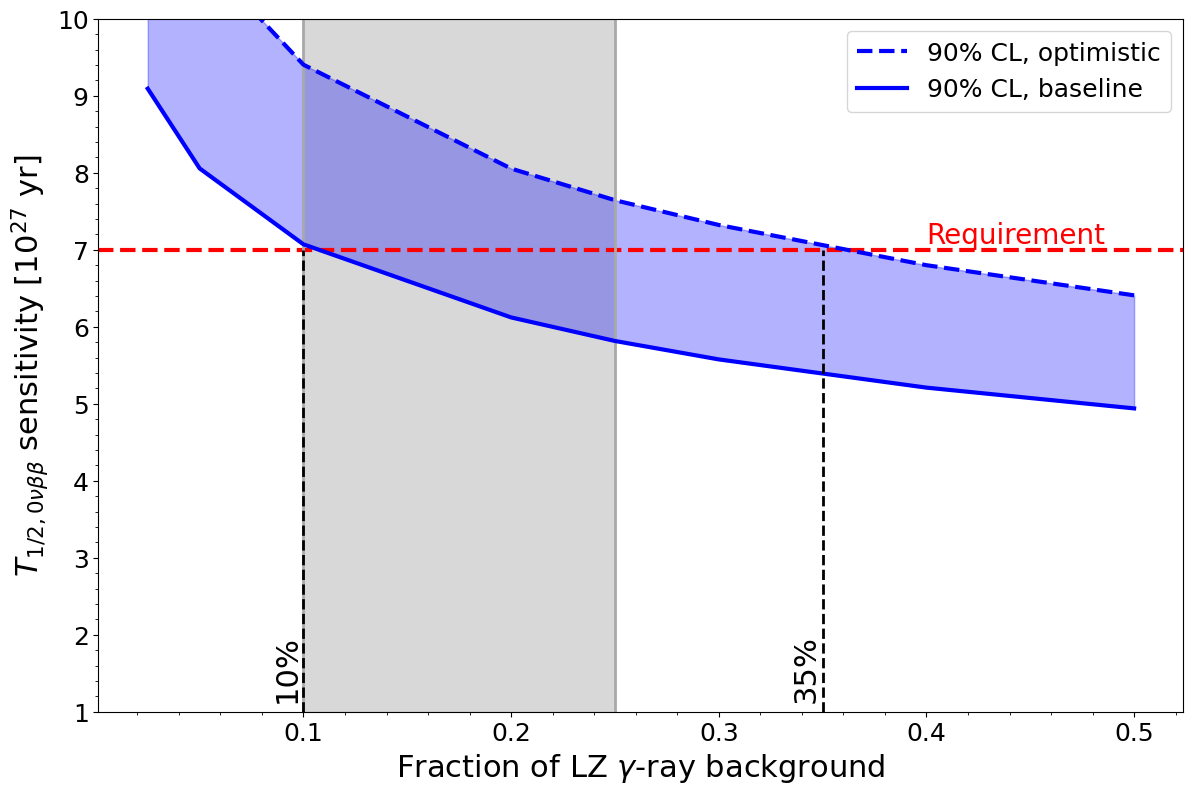

In [20]:
# Make the plot
fig, ax = plt.subplots(figsize = (14, 9))

# Requirement line
plt.axhline(7, ls = "--", lw = 3, color = "red")
plt.text(0.4, 7, 'Requirement', ha = 'left', va = 'bottom', color = 'red', size = 20)
# Band showing baseline and optimistic scenarios range
plt.vlines(0.1, 1, 10, lw = 2, color = "darkgrey")
#plt.text(0.095, 1.95e28, "progressive", va = "top", ha = "right",color = "dimgrey", size = 18, rotation = 90)
plt.vlines(0.25, 1, 10, lw = 2, color = "darkgrey")  
#plt.text(0.305, 1.95e28, "baseline", va = "top", ha = "left",color = "dimgrey", size = 18, rotation = 90)
plt.fill_betweenx([1,10], [0.1, 0.1], [0.25, 0.25], color ="grey", alpha = 0.3)

plt.plot(gamma_fractions_list, sens_vs_gammaFrac_optimistic, color =  'b', ls = '--', lw = 3, label = '90% CL, optimistic')
plt.plot(gamma_fractions_list, sens_vs_gammaFrac_baseline, color =  'b', ls = '-', lw = 3, label = '90% CL, baseline')
plt.fill_between(gamma_fractions_list, sens_vs_gammaFrac_baseline, sens_vs_gammaFrac_optimistic, color ="blue", alpha = 0.3)

# Add vertical lines showing gamma BG requirement
plt.vlines(0.1, 1, 7, lw = 2, ls = '--', color = 'k')
plt.text(0.085, 2., "10%", va = "top", ha = "left",color = "black", size = 22, rotation = 90)
plt.vlines(0.35, 1, 7, lw = 2, ls = '--', color = 'k')
plt.text(0.335, 2., "35%", va = "top", ha = "left",color = "black", size = 22, rotation = 90)

plt.minorticks_on() 
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel(r'Fraction of LZ $\gamma$-ray background')
plt.ylabel(r'$ T_{1/2, 0\nu\beta\beta}$ sensitivity [10$^{27}$ yr]')
plt.ylim(1.,10.)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

plt.legend()

## 2- HL vs $^{222}$Rn level

In [74]:
### XLZD baseline
# - 3 mm SS/MS in z-only
# - 0.65% Eres
# - 25% LZ gamma BG
# - 99.95% BiPo rejection (with 0.1 mBq/kg Rn-222)
# - installation in Boulby

# note that BiPo_eff is set to 99.98 here
baseline_input = [0.853, 0.767, 0.098, 0.65,  0.25, 99.98] # signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff
Lab_baseline = 'Boulby-1300'

### XLZD optimistic
# - 2 mm SS/MS in z-only
# - 0.6% Eres
# - 10% LZ gamma BG
# - 99.99% BiPo rejection (with 0.1 mBq/kg Rn-222)
# - installation in SURF

# note that BiPo_eff is set to 99.98 here
optimistic_input = [0.825, 0.739, 0.070, 0.60, 0.1, 99.98] # signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff
Lab_optimistic = 'Boulby-1300'

# - 60 t mass
# - 10 yr exposure time
LXeMass = 60
exposure = 10 # yr

In [82]:
# auxiliar calculation
Rn = 0.25
eff = 99.98
rn222 =  1.90e-4 * (Rn/0.1) * (100-eff)/(100-99.9)

print(9.5e-05, rn222)

9.5e-05 9.499999999998652e-05


In [75]:
rn_range_list = [0.0079, 0.05395, 0.1, 0.355, 0.61]
# these efficiencies *should* be equivalent to the above Rn levels for 99.98% efficiency
eff_list = [99.99842, 99.9892, 99.98, 99.929, 99.878]

sens_vs_rn_baseline = []
sens_vs_rn_optimistic = []
sens_vs_rn_requirement = []

for BiPo_eff in tqdm(eff_list):

    # baseline
    [signal_acc, beta_acc, gamma_acc, eres, gamma_frac, dummy] = baseline_input
    Lab = Lab_baseline
    gamma_args, beta_args = ['XLZD_1:1', LXeMass, gamma_frac], [Lab, BiPo_eff]
    FVmass_range = np.arange(0.1, 0.8*gamma_args[1], 0.1)
  
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_rn_baseline.append(sensitivity)

    # optimistic
    [signal_acc, beta_acc, gamma_acc, eres, gamma_frac, dummy] = optimistic_input
    Lab = Lab_optimistic
    gamma_args, beta_args = ['XLZD_1:1', LXeMass, gamma_frac], [Lab, BiPo_eff]
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_rn_optimistic.append(sensitivity)

    # "requirement" -- for gammas only
    [signal_acc, beta_acc, gamma_acc, eres, gamma_frac, dummy] = optimistic_input
    Lab = Lab_optimistic
    gamma_frac = 0.19
    gamma_args, beta_args = ['XLZD_1:1', LXeMass, gamma_frac], [Lab, BiPo_eff]
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_rn_requirement.append(sensitivity)

sens_vs_rn_baseline = np.array(sens_vs_rn_baseline)
sens_vs_rn_optimistic = np.array(sens_vs_rn_optimistic)
sens_vs_rn_requirement = np.array(sens_vs_rn_requirement)

# use a friendlier vertical scale
sens_vs_rn_baseline /= 1e27
sens_vs_rn_optimistic /= 1e27
sens_vs_rn_requirement /= 1e27

100%|██████████| 5/5 [00:01<00:00,  3.00it/s]


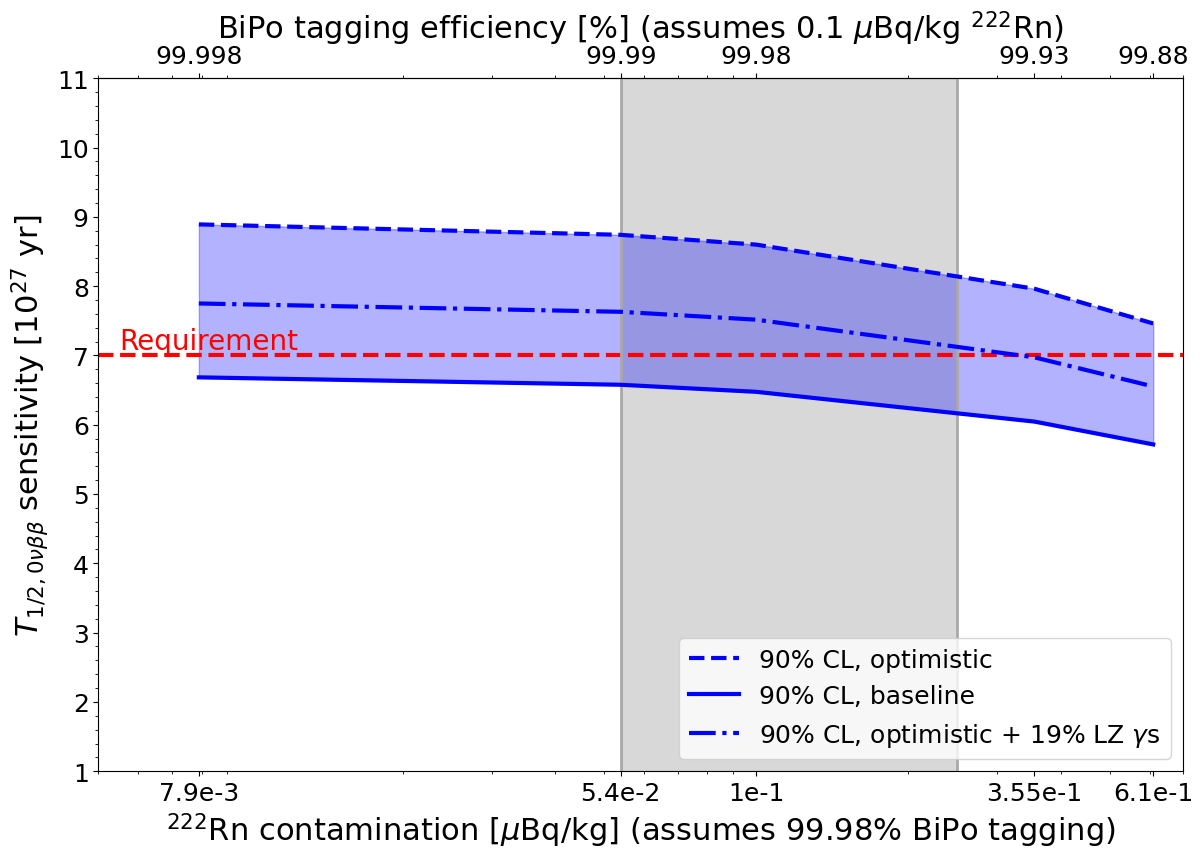

In [83]:
# Make the plot
fig, ax = plt.subplots(figsize = (14, 9))

# Requirement line
plt.axhline(7, ls = "--", lw = 3, color = "red")
plt.text(5.5e-3, 7, 'Requirement', ha = 'left', va = 'bottom', color = 'red', size = 20)
# Band showing baseline and optimistic scenarios range
plt.vlines(5.4e-2, 1, 11, lw = 2, color = "darkgrey")
#plt.text(0.095, 1.95e28, "progressive", va = "top", ha = "right",color = "dimgrey", size = 18, rotation = 90)
plt.vlines(2.5e-1, 1, 11, lw = 2, color = "darkgrey")  
#plt.text(0.305, 1.95e28, "baseline", va = "top", ha = "left",color = "dimgrey", size = 18, rotation = 90)
plt.fill_betweenx([1,11], [5.4e-2, 5.4e-2], [2.5e-1, 2.5e-1], color ="grey", alpha = 0.3)

plt.plot(rn_range_list, sens_vs_rn_optimistic, color =  'b', ls = '--', lw = 3, label = '90% CL, optimistic')
plt.plot(rn_range_list, sens_vs_rn_baseline, color =  'b', ls = '-', lw = 3, label = '90% CL, baseline')
plt.fill_between(rn_range_list, sens_vs_rn_baseline, sens_vs_rn_optimistic, color ="blue", alpha = 0.3)
plt.plot(rn_range_list, sens_vs_rn_requirement, color =  'b', ls = '-.', lw = 3, label = '90% CL, optimistic + 19% LZ $\gamma$s')

# Add vertical lines showing gamma BG requirement
#plt.vlines(0.1, 1, 7, lw = 2, ls = '--', color = 'k')
#plt.text(0.085, 2., "10%", va = "top", ha = "left",color = "black", size = 22, rotation = 90)
#plt.vlines(0.35, 1, 7, lw = 2, ls = '--', color = 'k')
#plt.text(0.335, 2., "35%", va = "top", ha = "left",color = "black", size = 22, rotation = 90)

plt.minorticks_on() 
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel(r'$^{222}$Rn contamination [$\mu$Bq/kg] (assumes 99.98% BiPo tagging)')
plt.ylabel(r'$ T_{1/2, 0\nu\beta\beta}$ sensitivity [10$^{27}$ yr]')
plt.ylim(1.,11.)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10','11'])
plt.xscale('log')
plt.xlim(5e-3,7e-1)
plt.xticks([0.0079, 0.05395, 0.1, 0.355, 0.61], [r'7.9e-3', '5.4e-2', '1e-1', '3.55e-1', '6.1e-1'])

def convert(x):
    return x
    
secax = ax.secondary_xaxis('top', functions=(convert, convert))
secax.set_xticks([0.0079, 0.05395, 0.1, 0.355, 0.61], ['99.998', '99.99', '99.98', '99.93', '99.88'])
secax.set_xlabel('BiPo tagging efficiency [%] (assumes 0.1 $\mu$Bq/kg $^{222}$Rn)')

plt.legend(loc = 'lower right')

plt.show()

## 3- HL vs Energy resolution

In [59]:
### XLZD baseline
# - 3 mm SS/MS in z-only
# - 0.65% Eres
# - 25% LZ gamma BG
# - 99.95% BiPo rejection (with 0.1 mBq/kg Rn-222)
# - installation in Boulby

# note that BiPo_eff is set to 99.98 here
baseline_input = [0.853, 0.767, 0.098, 0.65,  0.25, 99.95] # signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff
Lab_baseline = 'LNGS'

### XLZD optimistic
# - 2 mm SS/MS in z-only
# - 0.6% Eres
# - 10% LZ gamma BG
# - 99.99% BiPo rejection (with 0.1 mBq/kg Rn-222)
# - installation in SURF

# note that BiPo_eff is set to 99.98 here
optimistic_input = [0.825, 0.739, 0.070, 0.60, 0.1, 99.99] # signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff
Lab_optimistic = 'SURF'

# - 60 t mass
# - 10 yr exposure time
LXeMass = 60
exposure = 10 # yr

In [65]:
eres_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

sens_vs_eres_baseline = []
sens_vs_eres_optimistic = []
sens_vs_eres_requirement = []

for eres in tqdm(eres_list):

    # baseline
    [signal_acc, beta_acc, gamma_acc, dummy, gamma_frac, BiPo_eff] = baseline_input
    Lab = Lab_baseline
    gamma_args, beta_args = ['XLZD_1:1', LXeMass, gamma_frac], [Lab, BiPo_eff]
    FVmass_range = np.arange(0.1, 0.8*gamma_args[1], 0.1)
  
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_eres_baseline.append(sensitivity)

    # optimistic
    [signal_acc, beta_acc, gamma_acc, dummy, gamma_frac, BiPo_eff] = optimistic_input
    Lab = Lab_optimistic
    gamma_args, beta_args = ['XLZD_1:1', LXeMass, gamma_frac], [Lab, BiPo_eff]
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_eres_optimistic.append(sensitivity)

    # "requirement" -- for gammas only
    [signal_acc, beta_acc, gamma_acc, dummy, gamma_frac, BiPo_eff] = optimistic_input
    Lab = Lab_optimistic
    gamma_frac = 0.26
    gamma_args, beta_args = ['XLZD_1:1', LXeMass, gamma_frac], [Lab, BiPo_eff]
    sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                           gamma_args = gamma_args , beta_args = beta_args, \
                                           exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
    sens_vs_eres_requirement.append(sensitivity)


sens_vs_eres_baseline = np.array(sens_vs_eres_baseline)
sens_vs_eres_optimistic = np.array(sens_vs_eres_optimistic)
sens_vs_eres_requirement = np.array(sens_vs_eres_requirement)

# use a friendlier vertical scale
sens_vs_eres_baseline /= 1e27
sens_vs_eres_optimistic /= 1e27
sens_vs_eres_requirement /= 1e27

100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


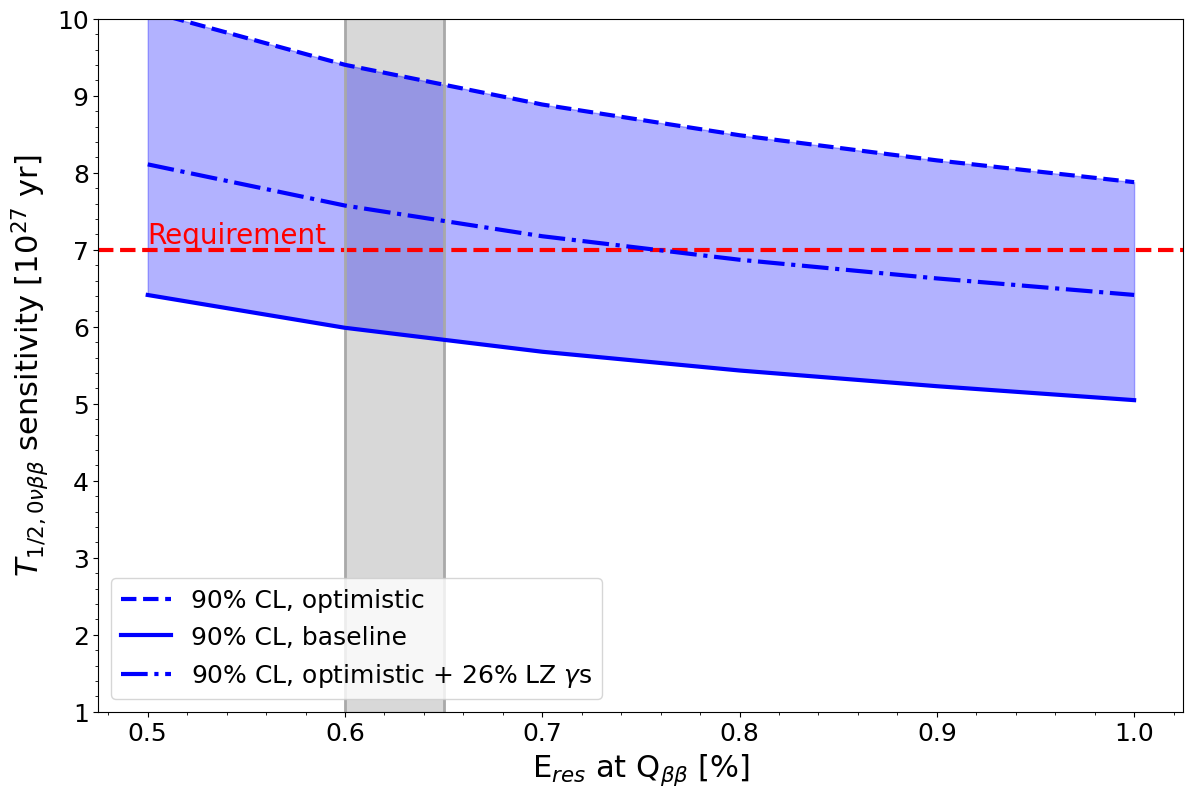

In [70]:
# Make the plot
fig, ax = plt.subplots(figsize = (14, 9))

# Requirement line
plt.axhline(7, ls = "--", lw = 3, color = "red")
plt.text(0.5, 7, 'Requirement', ha = 'left', va = 'bottom', color = 'red', size = 20)
# Band showing baseline and optimistic scenarios range
plt.vlines(0.6, 1, 10, lw = 2, color = "darkgrey")
#plt.text(0.095, 1.95e28, "progressive", va = "top", ha = "right",color = "dimgrey", size = 18, rotation = 90)
plt.vlines(0.65, 1, 10, lw = 2, color = "darkgrey")  
#plt.text(0.305, 1.95e28, "baseline", va = "top", ha = "left",color = "dimgrey", size = 18, rotation = 90)
plt.fill_betweenx([1,10], [0.6, 0.6], [0.65, 0.65], color ="grey", alpha = 0.3)

plt.plot(eres_list, sens_vs_eres_optimistic, color =  'b', ls = '--', lw = 3, label = '90% CL, optimistic')
plt.plot(eres_list, sens_vs_eres_baseline, color =  'b', ls = '-', lw = 3, label = '90% CL, baseline')
plt.fill_between(eres_list, sens_vs_eres_baseline, sens_vs_eres_optimistic, color ="blue", alpha = 0.3)
plt.plot(eres_list, sens_vs_eres_requirement, color =  'b', ls = '-.', lw = 3, label = '90% CL, optimistic + 26% LZ $\gamma$s')

# Add vertical lines showing gamma BG requirement
#plt.vlines(0.1, 1, 7, lw = 2, ls = '--', color = 'k')
#plt.text(0.085, 2., "10%", va = "top", ha = "left",color = "black", size = 22, rotation = 90)
#plt.vlines(0.35, 1, 7, lw = 2, ls = '--', color = 'k')
#plt.text(0.335, 2., "35%", va = "top", ha = "left",color = "black", size = 22, rotation = 90)

plt.minorticks_on() 
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel(r'E$_{res}$ at Q$_{\beta\beta}$ [%]')
plt.ylabel(r'$ T_{1/2, 0\nu\beta\beta}$ sensitivity [10$^{27}$ yr]')
plt.ylim(1.,10.)
plt.yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

plt.legend()

plt.show()

## Utility cell, to calculate a single sensitivity

In [69]:
# Get a single sensitivity
#                signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff
baseline_input = [0.853, 0.767, 0.098, 0.65,  0.25, 99.95]
Lab_baseline = "LNGS"
optimistic_input = [0.825, 0.739, 0.070, 0.60, 0.1, 99.99]
Lab_optimistic = "SURF"

requirements_input = [0.825, 0.739, 0.070, 0.65, 0.35, 99.98]
Lab_requirement = "SNOLab"

[signal_acc, beta_acc, gamma_acc, eres, gamma_frac, BiPo_eff], Lab = optimistic_input, Lab_optimistic
eres = 0.85
gamma_frac = 0.22

#gamma_args, beta_args = ['XLZD_shallow', 40, gamma_frac], ["SURF", BiPo_eff]
gamma_args, beta_args = ['XLZD_1:1', 60, gamma_frac], [Lab, BiPo_eff]
#gamma_args, beta_args = ['XLZD_tall', 80, gamma_frac], ["SURF", BiPo_eff]
FVmass_range = np.arange(0.1, 0.8*gamma_args[1], 0.1)
exposure = 10
#metric = "Disc_3sigma"
metric = "Excl_90p"
sensitivity = np.max(Sensitivity_curve(FVmass_range, signal_acc, beta_acc, gamma_acc, eres=eres, \
                                        gamma_args = gamma_args , beta_args = beta_args, \
                                        exposuretime = exposure, output = "long", metric = "Excl_90p")[0])
print(sensitivity)

7.014921568216913e+27
